# Shahid Ullah - 22I-2019
# Muhammad Salman - 22I-2027

In [1]:
%%capture
%pip install -q imbalanced-learn tldextract torch


In [2]:
import io
import math
import os
import re
import zipfile
from itertools import combinations
from pathlib import Path
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import tldextract

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.titlesize"] = 14

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Using device: cuda
GPU: Tesla T4


In [3]:
DATASETS = {
    "ai_generated_phishing_urls.csv": None,
    "PhiUSIIL_Phishing_URL_Dataset.csv": None,
}

# Determine where the script/notebook is running
workspace_root = Path.cwd()

# Check whether the required CSV files already exist in the current working directory
local_hits = {name: (workspace_root / name) for name in DATASETS}
missing = [name for name, path in local_hits.items() if not path.exists()]

# Directory used to store extracted datasets
data_dir = workspace_root / "uploaded_datasets"
data_dir.mkdir(exist_ok=True)

if missing:
    print("Uploading ZIP that bundles both CSV files...")
    try:
        from google.colab import files  # type: ignore

        uploads = files.upload()
        if not uploads:
            raise RuntimeError("No ZIP uploaded")
        zip_name, zip_bytes = next(iter(uploads.items()))
        with zipfile.ZipFile(io.BytesIO(zip_bytes)) as zf:
            zf.extractall(data_dir)
    except ModuleNotFoundError:
        raise ModuleNotFoundError(
            "google.colab not available. Place the CSV files next to the notebook or inside uploaded_datasets/."
        )
else:
    print("CSV files already present next to the notebook; skipping upload step.")

for csv_name in DATASETS:
    if local_hits[csv_name].exists():
        DATASETS[csv_name] = local_hits[csv_name]
    else:
        matches = list(data_dir.rglob(csv_name))
        if not matches:
            raise FileNotFoundError(f"Could not locate {csv_name} in extracted ZIP")
        DATASETS[csv_name] = matches[0]

DATASETS


Uploading ZIP that bundles both CSV files...


Saving dataset.zip to dataset.zip


{'ai_generated_phishing_urls.csv': PosixPath('/content/uploaded_datasets/ai_generated_phishing_urls.csv'),
 'PhiUSIIL_Phishing_URL_Dataset.csv': PosixPath('/content/uploaded_datasets/PhiUSIIL_Phishing_URL_Dataset.csv')}

In [4]:
ai_df = pd.read_csv(DATASETS["ai_generated_phishing_urls.csv"], encoding="utf-8", names=["url"], header=0)
phi_df = pd.read_csv(DATASETS["PhiUSIIL_Phishing_URL_Dataset.csv"], low_memory=False)

print(f"AI-generated rows: {len(ai_df):,}")
print(f"PhiUSIIL rows: {len(phi_df):,}")
phi_df.head(5)


AI-generated rows: 10,000
PhiUSIIL rows: 235,795


,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [5]:
# List of common terms frequently found in phishing URLs.
SUSPICIOUS_KEYWORDS = [
    "login",
    "update",
    "verify",
    "secure",
    "account",
    "signin",
    "invoice",
    "bank",
    "wallet",
    "support",
    "reset",
    "apple",
    "google",
    "microsoft",
    "facebook",
    "amazon",
    "paypal",
]

# Converts different label formats into a clean binary label:
def normalize_label(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, (int, float, np.integer, np.floating)):
        return int(value)
    text = str(value).strip().lower()
    if text.isdigit():
        return int(text)
    mapping = {
        "legitimate": 0,
        "benign": 0,
        "good": 0,
        "safe": 0,
        "phishing": 1,
        "malicious": 1,
        "bad": 1,
        "ai": 1,
        "ai-generated": 1,
    }
    return mapping.get(text, np.nan)

# Computes Shannon entropy of a URL string.
def shannon_entropy(value: str) -> float:
    if not value:
        return 0.0
    probs = [float(value.count(c)) / len(value) for c in set(value)]
    return -sum(p * math.log2(p) for p in probs if p > 0)

# Extracts a wide set of lexical (structure-based) URL features.
def extract_lexical_features(url: str) -> dict:
    url = str(url or "").strip()
    if not url:
        parsed = urlparse("http://placeholder")
        raw = ""
    else:
        raw = url
        if not re.match(r"^[a-zA-Z][a-zA-Z0-9+.-]*://", url):
            url = "http://" + url
        parsed = urlparse(url)

    netloc = parsed.netloc or parsed.path
    path = parsed.path
    query = parsed.query

    # Extract domain, suffix (TLD), and subdomain
    extracted = tldextract.extract(url)
    registered_domain = ".".join(part for part in [extracted.domain, extracted.suffix] if part)
    subdomain = extracted.subdomain

    # Character-based statistics
    specials = re.findall(r"[^\w]", raw)
    digits = [c for c in raw if c.isdigit()]
    letters = [c for c in raw if c.isalpha()]

    tokens = re.split(r"[\./:\-?_&=]+", raw)
    longest_token = max((len(tok) for tok in tokens if tok), default=0)

    # Final feature dictionary
    feature_dict = {
        "url_length": len(raw),
        "domain_length": len(netloc),
        "path_length": len(path),
        "query_length": len(query),
        "subdomain_length": len(subdomain),
        "subdomain_count": subdomain.count(".") + (1 if subdomain else 0),
        "digit_count": len(digits),
        "digit_ratio": len(digits) / len(raw) if raw else 0,
        "letter_ratio": len(letters) / len(raw) if raw else 0,
        "special_char_count": len(specials),
        "special_char_ratio": len(specials) / len(raw) if raw else 0,
        "hyphen_count": raw.count("-"),
        "dot_count": raw.count("."),
        "at_symbol_count": raw.count("@"),
        "has_https": 1 if raw.lower().startswith("https") else 0,
        "count_double_slash": raw.count("//"),
        "query_param_count": query.count("=") if query else 0,
        "suspicious_keyword_hits": sum(1 for kw in SUSPICIOUS_KEYWORDS if kw in raw.lower()),
        "token_max_length": longest_token,
        "tld_length": len(extracted.suffix or ""),
        "entropy": shannon_entropy(raw),
    }
    return feature_dict

# Builds a feature dataset for AI-generated phishing URLs.
def build_ai_dataset(df: pd.DataFrame) -> pd.DataFrame:
    features = df["url"].fillna("").apply(extract_lexical_features)
    feature_df = pd.DataFrame(features.tolist())
    feature_df["url"] = df["url"].fillna("")
    feature_df["label"] = 1
    feature_df["source"] = "ai_generated"
    return feature_df

# Builds a feature-enhanced dataset from the PhiUSIIL phishing dataset.
def build_phiusiil_dataset(df: pd.DataFrame) -> pd.DataFrame:
    working = df.copy()

    # Standardize URL field from different column names
    working["url"] = working["URL"].fillna(working.get("AI-Generated URL", "")).fillna("")
    working["label"] = working["label"].apply(normalize_label)

    # Compute lexical features
    lexical = working["url"].apply(extract_lexical_features)
    lexical_df = pd.DataFrame(lexical.tolist())

    # Include any numeric columns the dataset already has
    numeric_cols = working.select_dtypes(include=[np.number, "bool"]).columns.tolist()
    extra_df = working[numeric_cols].copy()

    # Merge everything into a single dataset
    merged = pd.concat([lexical_df, extra_df], axis=1)
    merged["url"] = working["url"].fillna("")
    merged["label"] = working["label"]
    merged["source"] = "phiusiil"
    return merged



Initial rows: 245,795
Rows removed due to missing url/label: 0
Duplicate urls removed: 431
Cleaned rows: 245,364
Top columns with missing values (pre-imputation):


,missing_count
ObfuscationRatio,9994
NoOfLettersInURL,9994
LetterRatioInURL,9994
NoOfDegitsInURL,9994
DegitRatioInURL,9994
URLLength,9994
DomainLength,9994
NoOfiFrame,9994
HasExternalFormSubmit,9994
HasSocialNet,9994


,count
label,
0,100520
1,144844


/tmp/ipython-input-1054511205.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index.astype(str), y=label_counts.values, palette="viridis")


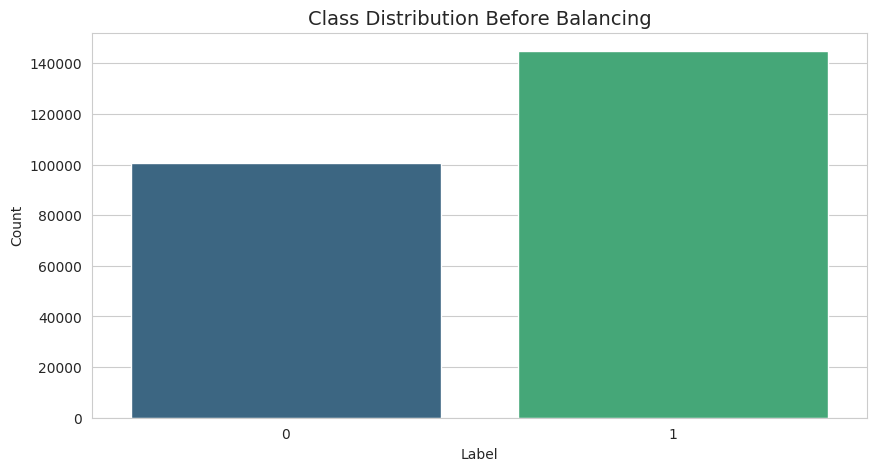

Training rows: 196,291
Hold-out rows (no resampling): 49,073


In [6]:
ai_features = build_ai_dataset(ai_df)
phi_features = build_phiusiil_dataset(phi_df)

combined_raw = pd.concat([ai_features, phi_features], ignore_index=True)
initial_rows = len(combined_raw)

combined_raw = combined_raw.dropna(subset=["url", "label"])
after_missing_rows = len(combined_raw)
missing_removed = initial_rows - after_missing_rows

duplicates_removed = combined_raw.duplicated(subset=["url"]).sum()
combined_raw = combined_raw.drop_duplicates(subset=["url"]).reset_index(drop=True)

print(f"Initial rows: {initial_rows:,}")
print(f"Rows removed due to missing url/label: {missing_removed:,}")
print(f"Duplicate urls removed: {duplicates_removed:,}")
print(f"Cleaned rows: {len(combined_raw):,}")

feature_columns = [col for col in combined_raw.columns if col not in {"label", "url", "source"}]
missing_summary = combined_raw[feature_columns].isna().sum().sort_values(ascending=False)
print("Top columns with missing values (pre-imputation):")
display(missing_summary.head(10).to_frame(name="missing_count"))

label_counts = combined_raw["label"].value_counts().sort_index()
display(label_counts.to_frame(name="count"))

plt.figure()
sns.barplot(x=label_counts.index.astype(str), y=label_counts.values, palette="viridis")
plt.title("Class Distribution Before Balancing")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

train_df, holdout_df = train_test_split(
    combined_raw, test_size=0.2, stratify=combined_raw["label"], random_state=42
)

print(f"Training rows: {len(train_df):,}")
print(f"Hold-out rows (no resampling): {len(holdout_df):,}")


Total missing values in training data before imputation: 401,500
Total missing values after median imputation: 0
Balanced training shape: (160832, 72)


,count
label,
0,80416
1,80416


/tmp/ipython-input-304271381.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=balanced_counts.index.astype(str), y=balanced_counts.values, palette="mako")


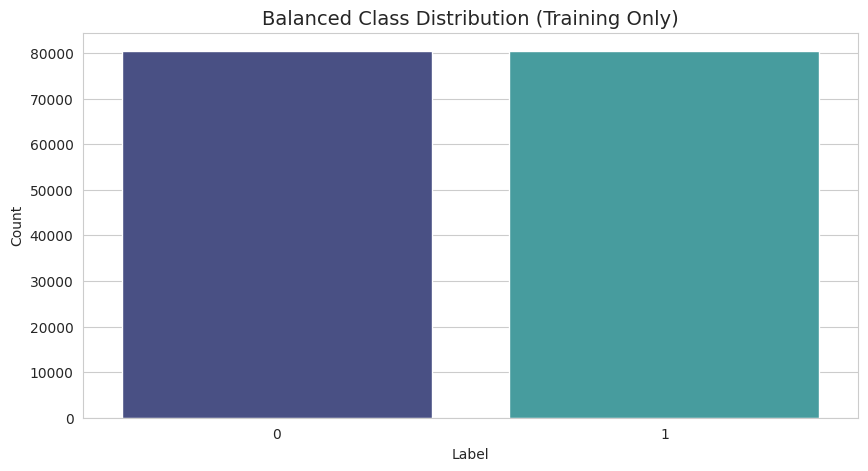

Hold-out class distribution (unbalanced):


,count
label,
0,20104
1,28969


In [7]:
feature_columns = [col for col in combined_raw.columns if col not in {"label", "url", "source"}]

X_train = train_df[feature_columns].apply(pd.to_numeric, errors="coerce")
X_holdout = holdout_df[feature_columns].apply(pd.to_numeric, errors="coerce")

X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_holdout = X_holdout.replace([np.inf, -np.inf], np.nan)

missing_before_impute = X_train.isna().sum().sum()
train_medians = X_train.median()
X_train = X_train.fillna(train_medians)
X_holdout = X_holdout.fillna(train_medians)
missing_after_impute = X_train.isna().sum().sum()

y_train = train_df["label"].astype(int)
y_holdout = holdout_df["label"].astype(int)

print(f"Total missing values in training data before imputation: {missing_before_impute:,}")
print(f"Total missing values after median imputation: {missing_after_impute:,}")

rus = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = rus.fit_resample(X_train, y_train)

balanced_df = pd.DataFrame(X_balanced, columns=feature_columns)
balanced_df["label"] = y_balanced

balanced_counts = pd.Series(y_balanced).value_counts().sort_index()
print("Balanced training shape:", balanced_df.shape)
display(balanced_counts.to_frame(name="count"))

plt.figure()
sns.barplot(x=balanced_counts.index.astype(str), y=balanced_counts.values, palette="mako")
plt.title("Balanced Class Distribution (Training Only)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

holdout_counts = y_holdout.value_counts().sort_index()
print("Hold-out class distribution (unbalanced):")
display(holdout_counts.to_frame(name="count"))


Top 10 feature-label correlations (absolute):


,abs_corr
URLSimilarityIndex,0.863491
HasSocialNet,0.728198
HasCopyrightInfo,0.685267
HasDescription,0.638366
IsHTTPS,0.616303
DomainTitleMatchScore,0.591378
IsResponsive,0.560829
URLTitleMatchScore,0.554084
SpacialCharRatioInURL,0.537915
HasSubmitButton,0.533684


No proxy features exceeded the correlation threshold.
CFS retained 25 / 71 features


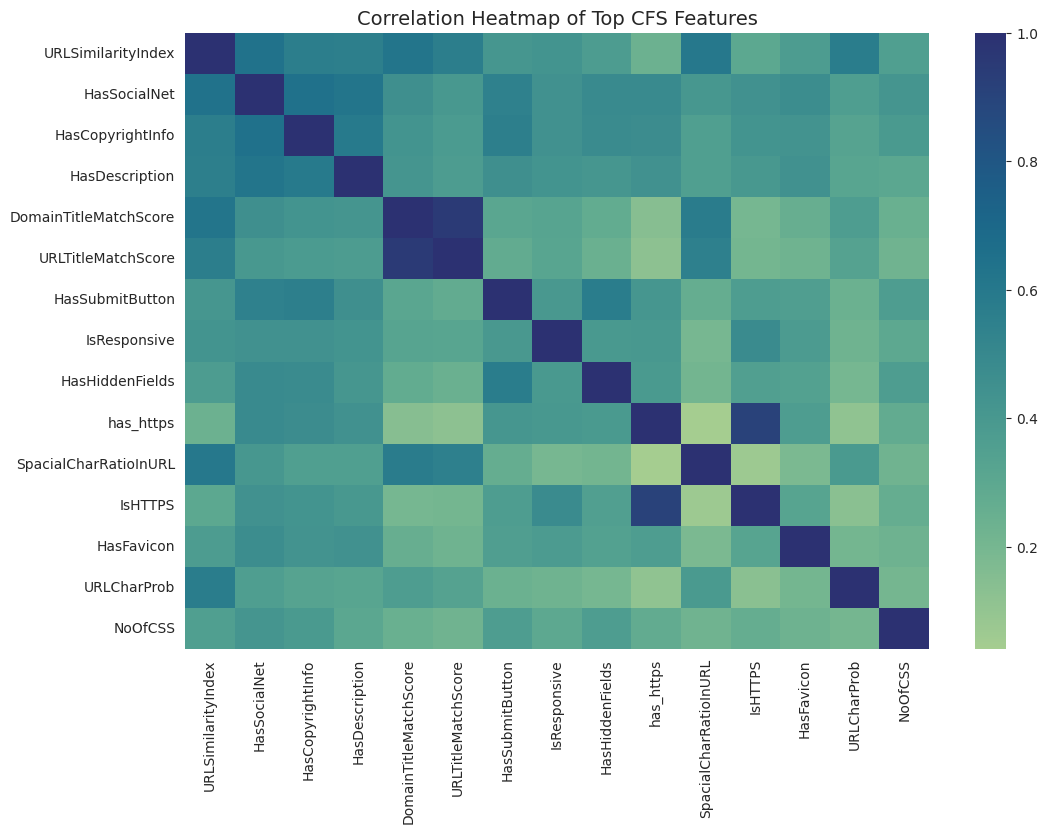

['URLSimilarityIndex',
 'IsHTTPS',
 'HasSocialNet',
 'HasCopyrightInfo',
 'DomainTitleMatchScore',
 'HasDescription',
 'IsResponsive',
 'SpacialCharRatioInURL',
 'LetterRatioInURL',
 'HasSubmitButton']

In [8]:
def safe_corr(series_a: pd.Series, series_b: pd.Series) -> float:
    corr = series_a.corr(series_b)
    return float(corr) if pd.notna(corr) else 0.0


def cfs_subset(X_df: pd.DataFrame, y_series: pd.Series, max_features: int = 30) -> list:
    target_corr = {col: abs(safe_corr(X_df[col], y_series)) for col in X_df.columns}
    feature_cache = {}

    def pair_corr(f1, f2):
        key = tuple(sorted((f1, f2)))
        if key not in feature_cache:
            feature_cache[key] = abs(safe_corr(X_df[f1], X_df[f2]))
        return feature_cache[key]

    ordered_features = sorted(X_df.columns, key=lambda c: target_corr[c], reverse=True)
    selected = []

    while ordered_features and len(selected) < max_features:
        best_feat = None
        best_merit = -np.inf
        for candidate in ordered_features:
            if candidate in selected:
                continue
            subset = selected + [candidate]
            k = len(subset)
            r_cf = np.mean([target_corr[feat] for feat in subset])
            if k == 1:
                r_ff = 0
            else:
                pairwise = [pair_corr(f1, f2) for f1, f2 in combinations(subset, 2)]
                r_ff = np.mean(pairwise) if pairwise else 0
            merit = (k * r_cf) / math.sqrt(k + k * (k - 1) * r_ff + 1e-9)
            if merit > best_merit:
                best_merit = merit
                best_feat = candidate
        if best_feat is None:
            break
        selected.append(best_feat)
        ordered_features.remove(best_feat)
    return selected


train_label_corr = X_train.corrwith(y_train)
label_corr_df = train_label_corr.abs().sort_values(ascending=False).to_frame(name="abs_corr")
print("Top 10 feature-label correlations (absolute):")
display(label_corr_df.head(10))

PROXY_THRESHOLD = 0.98
proxy_features = label_corr_df[label_corr_df["abs_corr"] >= PROXY_THRESHOLD].index.tolist()
if proxy_features:
    print(f"Removing {len(proxy_features)} proxy feature(s) with |corr| >= {PROXY_THRESHOLD}:")
    print(proxy_features)
    feature_columns = [col for col in feature_columns if col not in proxy_features]
    X_train = X_train.drop(columns=proxy_features)
    X_holdout = X_holdout.drop(columns=proxy_features)
    balanced_df = balanced_df.drop(columns=proxy_features)
else:
    print("No proxy features exceeded the correlation threshold.")

selected_features = cfs_subset(balanced_df[feature_columns], balanced_df["label"], max_features=25)
print(f"CFS retained {len(selected_features)} / {len(feature_columns)} features")

corr_subset = balanced_df[selected_features].corr().abs()
top_corr_feats = corr_subset.mean().sort_values(ascending=False).head(15).index

plt.figure(figsize=(12, 8))
sns.heatmap(corr_subset.loc[top_corr_feats, top_corr_feats], cmap="crest", annot=False)
plt.title("Correlation Heatmap of Top CFS Features")
plt.show()

selected_features[:10]


/tmp/ipython-input-396154375.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="metric", y="score", data=metrics_long, palette="Blues_d")


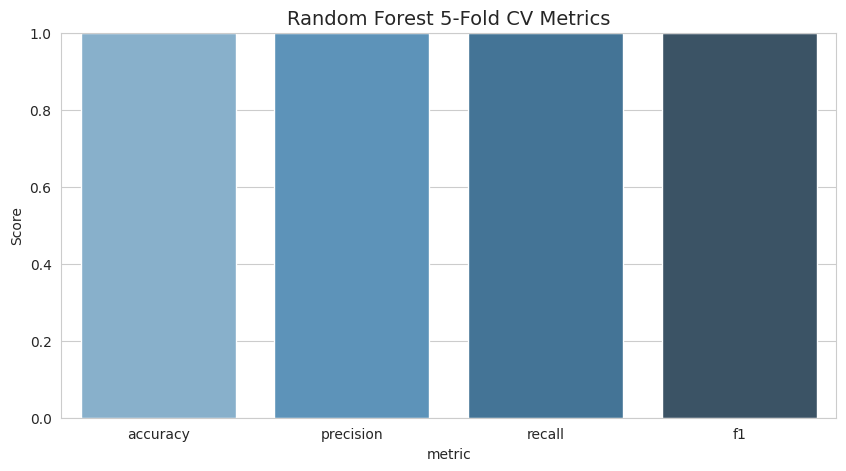

,accuracy,precision,recall,f1
0,0.999919,0.999838,1.0,0.999919


In [9]:
X_cfs = balanced_df[selected_features]
y_cfs = balanced_df["label"].astype(int)
X_holdout_cfs = X_holdout[selected_features]

rf_model = RandomForestClassifier(
    n_estimators=250,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features="sqrt",
    criterion="entropy",
    random_state=42,
    n_jobs=-1,
)


def cross_validate_random_forest(X_df, y_series, estimator, folds=5):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    fold_metrics = []

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_df, y_series), start=1):
        X_train, X_val = X_df.iloc[train_idx], X_df.iloc[val_idx]
        y_train, y_val = y_series.iloc[train_idx], y_series.iloc[val_idx]

        model = clone(estimator)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        fold_metrics.append(
            {
                "fold": fold_idx,
                "accuracy": accuracy_score(y_val, y_pred),
                "precision": precision_score(y_val, y_pred),
                "recall": recall_score(y_val, y_pred),
                "f1": f1_score(y_val, y_pred),
            }
        )

    return pd.DataFrame(fold_metrics)


rf_cv_folds = cross_validate_random_forest(X_cfs, y_cfs, rf_model, folds=5)
rf_cv_summary = rf_cv_folds[["accuracy", "precision", "recall", "f1"]].mean().to_frame().T

metrics_long = rf_cv_summary.melt(var_name="metric", value_name="score")
plt.figure()
sns.barplot(x="metric", y="score", data=metrics_long, palette="Blues_d")
plt.ylim(0, 1)
plt.title("Random Forest 5-Fold CV Metrics")
plt.ylabel("Score")
plt.show()

rf_cv_summary


Random Forest trained on all balanced data.
Per-fold CV metrics:


,fold,accuracy,precision,recall,f1
0,1,0.999907,0.999814,1.0,0.999907
1,2,0.999907,0.999814,1.0,0.999907
2,3,0.999938,0.999876,1.0,0.999938
3,4,0.999938,0.999876,1.0,0.999938
4,5,0.999907,0.999814,1.0,0.999907


Mean CV metrics:


,accuracy,precision,recall,f1
0,0.999919,0.999838,1.0,0.999919


Hold-out metrics (unseen, unbalanced data):


,accuracy,precision,recall,f1
0,0.999939,0.999896,1.0,0.999948


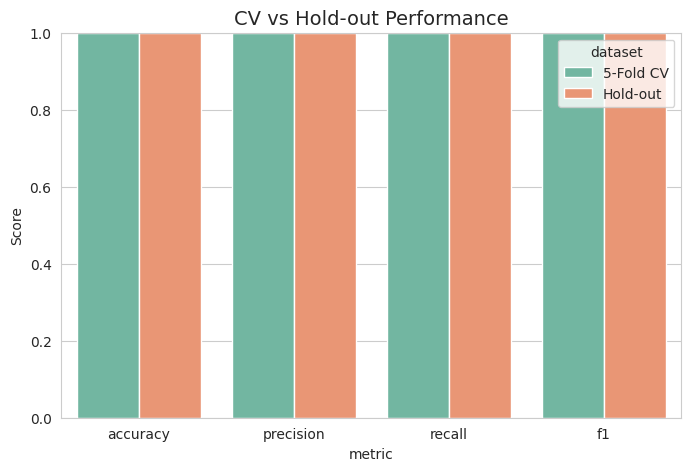

,importance
URLSimilarityIndex,0.315864
NoOfImage,0.165858
NoOfExternalRef,0.152594
NoOfJS,0.093130
NoOfCSS,0.059002
HasSocialNet,0.048597
HasCopyrightInfo,0.039925
IsHTTPS,0.022009
HasDescription,0.018505
subdomain_length,0.017501


/tmp/ipython-input-2352319615.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df.values, y=importance_df.index, palette="rocket")


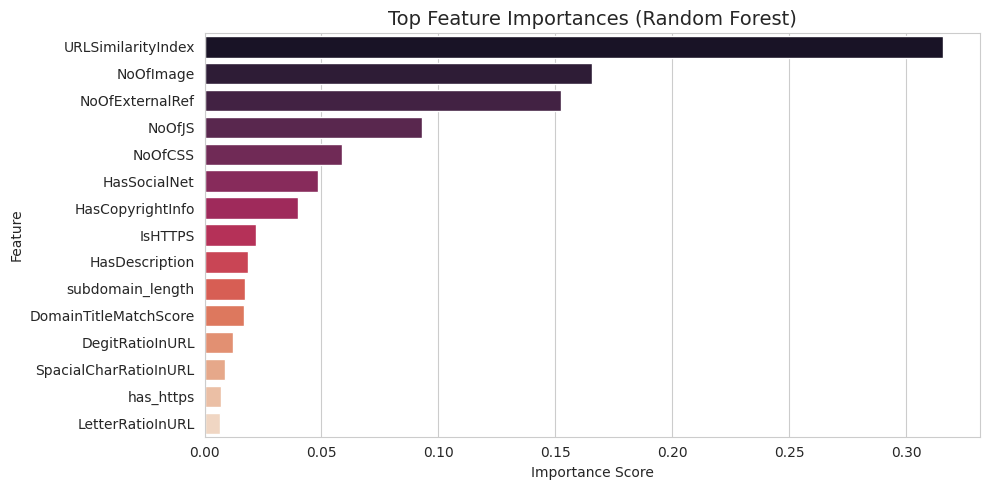

,accuracy,precision,recall,f1
0,0.999919,0.999838,1.0,0.999919


In [10]:
final_rf = clone(rf_model)
final_rf.fit(X_cfs, y_cfs)

print("Random Forest trained on all balanced data.")
print("Per-fold CV metrics:")
display(rf_cv_folds)
print("Mean CV metrics:")
display(rf_cv_summary)

holdout_pred = final_rf.predict(X_holdout_cfs)
holdout_metrics = pd.DataFrame(
    {
        "accuracy": [accuracy_score(y_holdout, holdout_pred)],
        "precision": [precision_score(y_holdout, holdout_pred)],
        "recall": [recall_score(y_holdout, holdout_pred)],
        "f1": [f1_score(y_holdout, holdout_pred)],
    }
)
print("Hold-out metrics (unseen, unbalanced data):")
display(holdout_metrics)

comparison_df = pd.concat(
    [
        rf_cv_summary.assign(dataset="5-Fold CV"),
        holdout_metrics.assign(dataset="Hold-out"),
    ]
)
comparison_long = comparison_df.melt(id_vars="dataset", var_name="metric", value_name="score")
plt.figure(figsize=(8, 5))
sns.barplot(x="metric", y="score", hue="dataset", data=comparison_long, palette="Set2")
plt.ylim(0, 1)
plt.title("CV vs Hold-out Performance")
plt.ylabel("Score")
plt.show()

importance_df = pd.Series(final_rf.feature_importances_, index=selected_features).sort_values(ascending=False).head(15)
display(importance_df.to_frame(name="importance"))

plt.figure()
sns.barplot(x=importance_df.values, y=importance_df.index, palette="rocket")
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

rf_cv_summary


In [ ]:
# Custom Dataset class for PyTorch
class URLDataset(Dataset):
    """PyTorch Dataset for URL features"""
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features.values if isinstance(features, pd.DataFrame) else features)
        self.labels = torch.LongTensor(labels.values if isinstance(labels, pd.Series) else labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


# Model 1: Multi-Layer Perceptron (MLP) with Dropout
class MLPClassifier(nn.Module):
    """Deep Neural Network with multiple hidden layers and dropout for regularization"""
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], dropout_rate=0.3):
        super(MLPClassifier, self).__init__()
        layers = []
        prev_dim = input_dim

        # Build hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim

        # Output layer
        layers.append(nn.Linear(prev_dim, 2))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


# Model 2: Advanced Neural Network with Residual Connections
class ResidualBlock(nn.Module):
    """Residual block with skip connection for better gradient flow"""
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual  # Skip connection
        out = self.relu(out)
        return out


class AdvancedNNClassifier(nn.Module):
    """Advanced Neural Network with residual connections and attention mechanism"""
    def __init__(self, input_dim, hidden_dim=128, num_residual_blocks=2):
        super(AdvancedNNClassifier, self).__init__()

        # Initial projection
        self.input_projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )

        # Residual blocks
        self.residual_blocks = nn.ModuleList([
            ResidualBlock(hidden_dim) for _ in range(num_residual_blocks)
        ])

        # Attention mechanism for feature importance
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.Sigmoid()
        )

        # Final classification layers
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, 2)
        )

    def forward(self, x):
        # Initial projection
        x = self.input_projection(x)

        # Pass through residual blocks
        for block in self.residual_blocks:
            x = block(x)

        # Apply attention
        attention_weights = self.attention(x)
        x = x * attention_weights

        # Final classification
        return self.classifier(x)


def train_model(model, train_loader, val_loader, epochs=50, lr=0.001, device=device):
    """Train a PyTorch model with early stopping"""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 10
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return model, train_losses, val_losses


def evaluate_model(model, data_loader, device=device):
    """Evaluate model and return predictions and true labels"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for features, labels in data_loader:
            features = features.to(device)
            outputs = model(features)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)


def cross_validate_deep_learning(X_df, y_series, model_class, model_params, folds=5, epochs=50, batch_size=256, device=device):
    """Perform cross-validation for deep learning models"""
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    fold_metrics = []

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_df)

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y_series), start=1):
        X_train_fold = X_scaled[train_idx]
        X_val_fold = X_scaled[val_idx]
        y_train_fold = y_series.iloc[train_idx].values
        y_val_fold = y_series.iloc[val_idx].values

        # Create data loaders
        train_dataset = URLDataset(X_train_fold, y_train_fold)
        val_dataset = URLDataset(X_val_fold, y_val_fold)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model
        input_dim = X_train_fold.shape[1]
        model = model_class(input_dim=input_dim, **model_params)

        # Train model
        model, _, _ = train_model(model, train_loader, val_loader, epochs=epochs, device=device)

        # Evaluate
        y_pred, y_true = evaluate_model(model, val_loader, device=device)

        fold_metrics.append({
            "fold": fold_idx,
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred),
            "recall": recall_score(y_true, y_pred),
            "f1": f1_score(y_true, y_pred),
        })

        print(f"Fold {fold_idx} completed - F1: {fold_metrics[-1]['f1']:.4f}")

    return pd.DataFrame(fold_metrics)

print("Deep learning utilities and models defined successfully!")


Deep learning utilities and models defined successfully!


Training Model 1: Multi-Layer Perceptron (MLP)

Performing 5-fold cross-validation for MLP...
Early stopping at epoch 31
Fold 1 completed - F1: 0.9998
Early stopping at epoch 21
Fold 2 completed - F1: 0.9999
Early stopping at epoch 15
Fold 3 completed - F1: 0.9998
Early stopping at epoch 23
Fold 4 completed - F1: 1.0000
Early stopping at epoch 25
Fold 5 completed - F1: 0.9999

MLP Cross-Validation Results:
Per-fold metrics:


,fold,accuracy,precision,recall,f1
0,1,0.999845,0.999689,1.0,0.999845
1,2,0.999938,0.999876,1.0,0.999938
2,3,0.999845,0.999689,1.0,0.999845
3,4,1.000000,1.000000,1.0,1.000000
4,5,0.999907,0.999814,1.0,0.999907



Mean CV metrics:


,accuracy,precision,recall,f1
0,0.999907,0.999814,1.0,0.999907


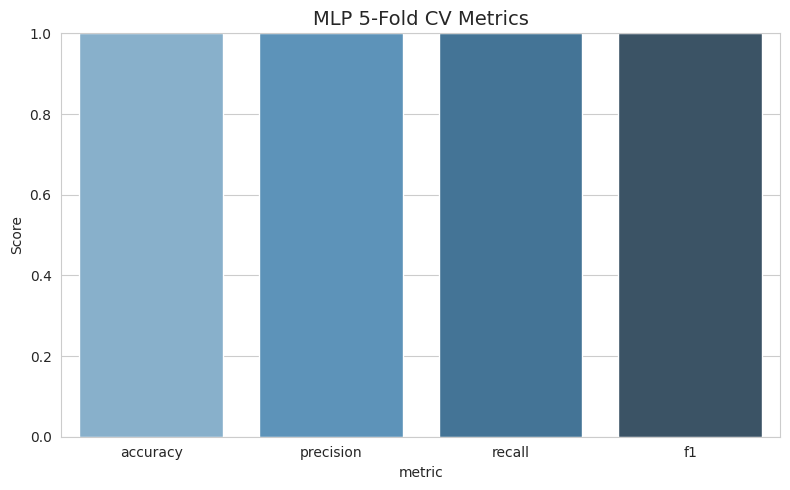


Training final MLP model on all balanced data...
Early stopping at epoch 28

Evaluating MLP on hold-out set...
MLP Hold-out metrics:


,accuracy,precision,recall,f1
0,0.999959,0.999931,1.0,0.999965


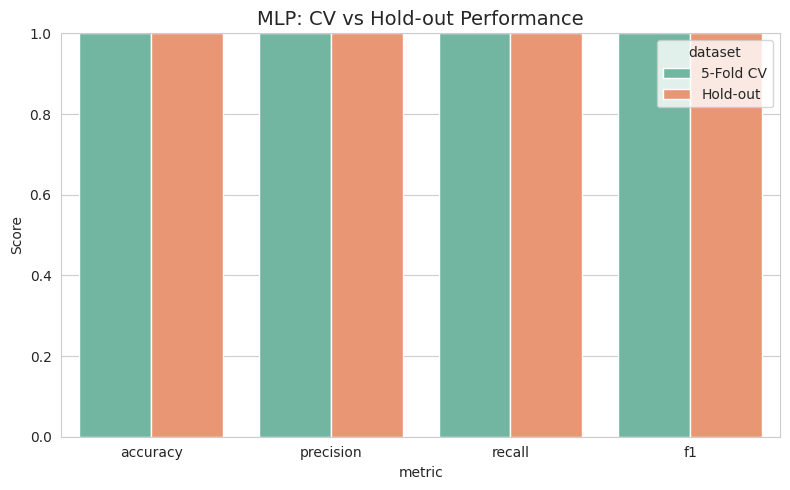

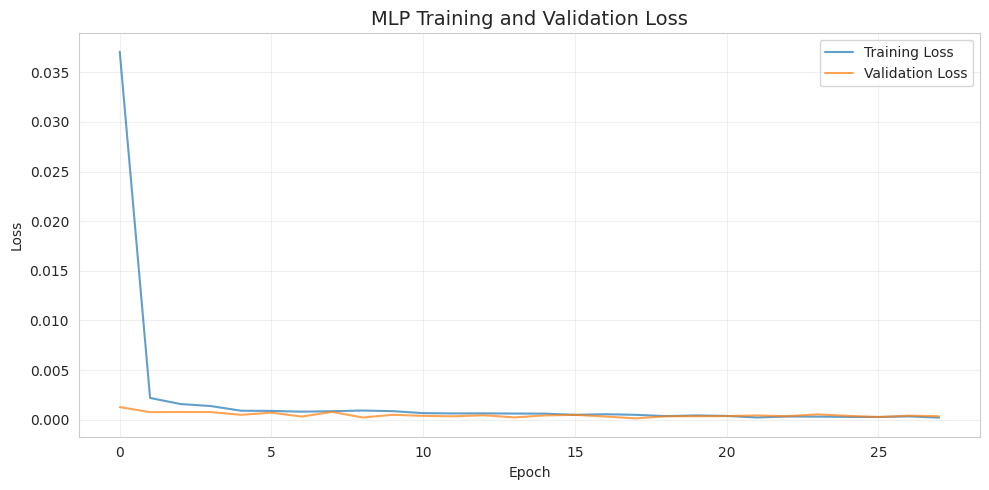


MLP Model Training Complete!


In [14]:
print("=" * 70)
print("Training Model 1: Multi-Layer Perceptron (MLP)")
print("=" * 70)

# Prepare data for MLP
X_mlp = X_cfs.copy()
y_mlp = y_cfs.copy()

# MLP model parameters
mlp_params = {
    "hidden_dims": [128, 64, 32],
    "dropout_rate": 0.3
}

# Cross-validation for MLP
print("\nPerforming 5-fold cross-validation for MLP...")
mlp_cv_folds = cross_validate_deep_learning(
    X_mlp, y_mlp,
    model_class=MLPClassifier,
    model_params=mlp_params,
    folds=5,
    epochs=50,
    batch_size=256,
    device=device
)

mlp_cv_summary = mlp_cv_folds[["accuracy", "precision", "recall", "f1"]].mean().to_frame().T

print("\nMLP Cross-Validation Results:")
print("Per-fold metrics:")
display(mlp_cv_folds)
print("\nMean CV metrics:")
display(mlp_cv_summary)

# Visualize CV metrics
metrics_long = mlp_cv_summary.melt(var_name="metric", value_name="score")
plt.figure(figsize=(8, 5))
sns.barplot(x="metric", y="score", data=metrics_long, palette="Blues_d", hue="metric", legend=False)
plt.ylim(0, 1)
plt.title("MLP 5-Fold CV Metrics")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

# Train final MLP model on all balanced data
print("\nTraining final MLP model on all balanced data...")
scaler_mlp = StandardScaler()
X_mlp_scaled = scaler_mlp.fit_transform(X_mlp)
train_dataset_mlp = URLDataset(X_mlp_scaled, y_mlp.values)
train_loader_mlp = DataLoader(train_dataset_mlp, batch_size=256, shuffle=True)

# Create validation split for early stopping
val_size = int(0.1 * len(X_mlp_scaled))
train_size = len(X_mlp_scaled) - val_size
train_data, val_data = torch.utils.data.random_split(
    train_dataset_mlp, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)
train_loader_final = DataLoader(train_data, batch_size=256, shuffle=True)
val_loader_final = DataLoader(val_data, batch_size=256, shuffle=False)

final_mlp = MLPClassifier(input_dim=X_mlp_scaled.shape[1], **mlp_params)
final_mlp, train_losses, val_losses = train_model(
    final_mlp, train_loader_final, val_loader_final,
    epochs=50, device=device
)

# Evaluate on holdout set
print("\nEvaluating MLP on hold-out set...")
X_holdout_mlp_scaled = scaler_mlp.transform(X_holdout_cfs)
holdout_dataset_mlp = URLDataset(X_holdout_mlp_scaled, y_holdout.values)
holdout_loader_mlp = DataLoader(holdout_dataset_mlp, batch_size=256, shuffle=False)

mlp_holdout_pred, mlp_holdout_true = evaluate_model(final_mlp, holdout_loader_mlp, device=device)

mlp_holdout_metrics = pd.DataFrame({
    "accuracy": [accuracy_score(mlp_holdout_true, mlp_holdout_pred)],
    "precision": [precision_score(mlp_holdout_true, mlp_holdout_pred)],
    "recall": [recall_score(mlp_holdout_true, mlp_holdout_pred)],
    "f1": [f1_score(mlp_holdout_true, mlp_holdout_pred)],
})

print("MLP Hold-out metrics:")
display(mlp_holdout_metrics)

# Comparison visualization
mlp_comparison_df = pd.concat([
    mlp_cv_summary.assign(dataset="5-Fold CV"),
    mlp_holdout_metrics.assign(dataset="Hold-out"),
])
mlp_comparison_long = mlp_comparison_df.melt(id_vars="dataset", var_name="metric", value_name="score")
plt.figure(figsize=(8, 5))
sns.barplot(x="metric", y="score", hue="dataset", data=mlp_comparison_long, palette="Set2")
plt.ylim(0, 1)
plt.title("MLP: CV vs Hold-out Performance")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

# Training loss visualization
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss", alpha=0.7)
plt.plot(val_losses, label="Validation Loss", alpha=0.7)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP Training and Validation Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("MLP Model Training Complete!")
print("=" * 70)


Training Model 2: Advanced NN with Residual Connections

Performing 5-fold cross-validation for Advanced NN...
Early stopping at epoch 14
Fold 1 completed - F1: 0.9998
Early stopping at epoch 30
Fold 2 completed - F1: 1.0000
Early stopping at epoch 27
Fold 3 completed - F1: 0.9999
Early stopping at epoch 34
Fold 4 completed - F1: 1.0000
Early stopping at epoch 39
Fold 5 completed - F1: 1.0000

Advanced NN Cross-Validation Results:
Per-fold metrics:


,fold,accuracy,precision,recall,f1
0,1,0.999782,0.999565,1.000000,0.999782
1,2,0.999969,0.999938,1.000000,0.999969
2,3,0.999876,0.999751,1.000000,0.999876
3,4,1.000000,1.000000,1.000000,1.000000
4,5,0.999969,1.000000,0.999938,0.999969



Mean CV metrics:


,accuracy,precision,recall,f1
0,0.999919,0.999851,0.999988,0.999919


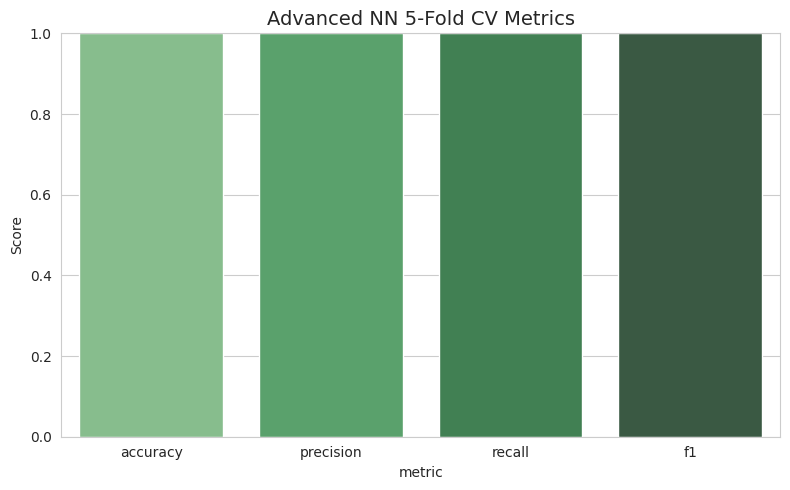


Training final Advanced NN model on all balanced data...
Early stopping at epoch 14

Evaluating Advanced NN on hold-out set...
Advanced NN Hold-out metrics:


,accuracy,precision,recall,f1
0,0.999918,0.999931,0.999931,0.999931


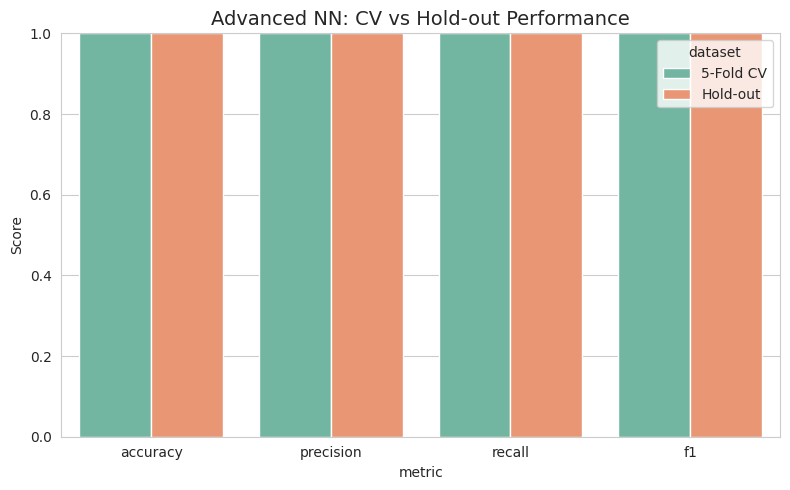

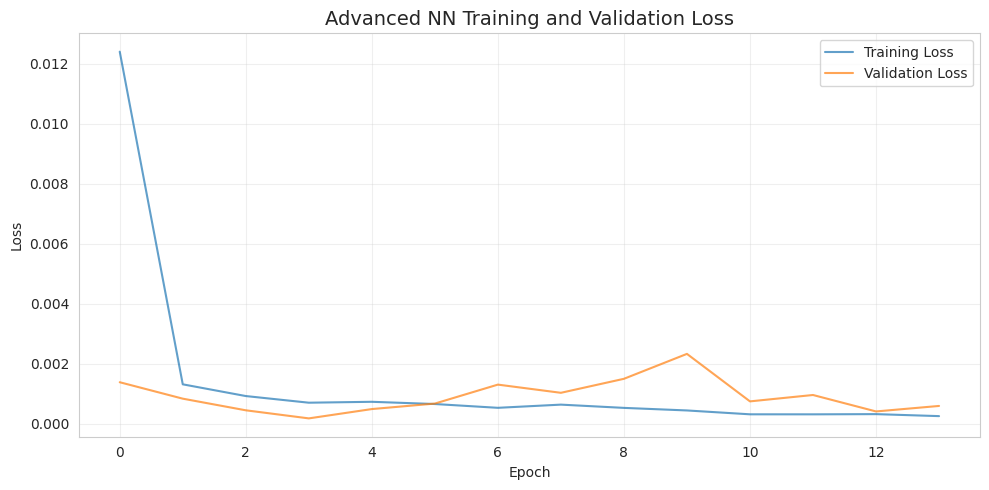


Advanced NN Model Training Complete!


In [15]:
print("=" * 70)
print("Training Model 2: Advanced NN with Residual Connections")
print("=" * 70)

# Prepare data for Advanced NN
X_adv = X_cfs.copy()
y_adv = y_cfs.copy()

# Advanced NN model parameters
adv_nn_params = {
    "hidden_dim": 128,
    "num_residual_blocks": 2
}

# Cross-validation for Advanced NN
print("\nPerforming 5-fold cross-validation for Advanced NN...")
adv_nn_cv_folds = cross_validate_deep_learning(
    X_adv, y_adv,
    model_class=AdvancedNNClassifier,
    model_params=adv_nn_params,
    folds=5,
    epochs=50,
    batch_size=256,
    device=device
)

adv_nn_cv_summary = adv_nn_cv_folds[["accuracy", "precision", "recall", "f1"]].mean().to_frame().T

print("\nAdvanced NN Cross-Validation Results:")
print("Per-fold metrics:")
display(adv_nn_cv_folds)
print("\nMean CV metrics:")
display(adv_nn_cv_summary)

# Visualize CV metrics
metrics_long = adv_nn_cv_summary.melt(var_name="metric", value_name="score")
plt.figure(figsize=(8, 5))
sns.barplot(x="metric", y="score", data=metrics_long, palette="Greens_d", hue="metric", legend=False)
plt.ylim(0, 1)
plt.title("Advanced NN 5-Fold CV Metrics")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

# Train final Advanced NN model on all balanced data
print("\nTraining final Advanced NN model on all balanced data...")
scaler_adv = StandardScaler()
X_adv_scaled = scaler_adv.fit_transform(X_adv)
train_dataset_adv = URLDataset(X_adv_scaled, y_adv.values)
train_loader_adv = DataLoader(train_dataset_adv, batch_size=256, shuffle=True)

# Create validation split for early stopping
val_size = int(0.1 * len(X_adv_scaled))
train_size = len(X_adv_scaled) - val_size
train_data_adv, val_data_adv = torch.utils.data.random_split(
    train_dataset_adv, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)
train_loader_final_adv = DataLoader(train_data_adv, batch_size=256, shuffle=True)
val_loader_final_adv = DataLoader(val_data_adv, batch_size=256, shuffle=False)

final_adv_nn = AdvancedNNClassifier(input_dim=X_adv_scaled.shape[1], **adv_nn_params)
final_adv_nn, train_losses_adv, val_losses_adv = train_model(
    final_adv_nn, train_loader_final_adv, val_loader_final_adv,
    epochs=50, device=device
)

# Evaluate on holdout set
print("\nEvaluating Advanced NN on hold-out set...")
X_holdout_adv_scaled = scaler_adv.transform(X_holdout_cfs)
holdout_dataset_adv = URLDataset(X_holdout_adv_scaled, y_holdout.values)
holdout_loader_adv = DataLoader(holdout_dataset_adv, batch_size=256, shuffle=False)

adv_nn_holdout_pred, adv_nn_holdout_true = evaluate_model(final_adv_nn, holdout_loader_adv, device=device)

adv_nn_holdout_metrics = pd.DataFrame({
    "accuracy": [accuracy_score(adv_nn_holdout_true, adv_nn_holdout_pred)],
    "precision": [precision_score(adv_nn_holdout_true, adv_nn_holdout_pred)],
    "recall": [recall_score(adv_nn_holdout_true, adv_nn_holdout_pred)],
    "f1": [f1_score(adv_nn_holdout_true, adv_nn_holdout_pred)],
})

print("Advanced NN Hold-out metrics:")
display(adv_nn_holdout_metrics)

# Comparison visualization
adv_nn_comparison_df = pd.concat([
    adv_nn_cv_summary.assign(dataset="5-Fold CV"),
    adv_nn_holdout_metrics.assign(dataset="Hold-out"),
])
adv_nn_comparison_long = adv_nn_comparison_df.melt(id_vars="dataset", var_name="metric", value_name="score")
plt.figure(figsize=(8, 5))
sns.barplot(x="metric", y="score", hue="dataset", data=adv_nn_comparison_long, palette="Set2")
plt.ylim(0, 1)
plt.title("Advanced NN: CV vs Hold-out Performance")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

# Training loss visualization
plt.figure(figsize=(10, 5))
plt.plot(train_losses_adv, label="Training Loss", alpha=0.7)
plt.plot(val_losses_adv, label="Validation Loss", alpha=0.7)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Advanced NN Training and Validation Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("Advanced NN Model Training Complete!")
print("=" * 70)


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve,
    classification_report
)

In [ ]:
# Custom Dataset class for PyTorch
class URLDataset(Dataset):
    """PyTorch Dataset for URL features"""
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features.values if isinstance(features, pd.DataFrame) else features)
        self.labels = torch.LongTensor(labels.values if isinstance(labels, pd.Series) else labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


# Model 1: Multi-Layer Perceptron (MLP) with Dropout
class MLPClassifier(nn.Module):
    """Deep Neural Network with multiple hidden layers and dropout for regularization"""
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], dropout_rate=0.3):
        super(MLPClassifier, self).__init__()
        layers = []
        prev_dim = input_dim

        # Build hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim

        # Output layer
        layers.append(nn.Linear(prev_dim, 2))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


# Model 2: Advanced Neural Network with Residual Connections
class ResidualBlock(nn.Module):
    """Residual block with skip connection for better gradient flow"""
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual  # Skip connection
        out = self.relu(out)
        return out


class AdvancedNNClassifier(nn.Module):
    """Advanced Neural Network with residual connections and attention mechanism"""
    def __init__(self, input_dim, hidden_dim=128, num_residual_blocks=2):
        super(AdvancedNNClassifier, self).__init__()

        # Initial projection
        self.input_projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )

        # Residual blocks
        self.residual_blocks = nn.ModuleList([
            ResidualBlock(hidden_dim) for _ in range(num_residual_blocks)
        ])

        # Attention mechanism for feature importance
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.Sigmoid()
        )

        # Final classification layers
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, 2)
        )

    def forward(self, x):
        # Initial projection
        x = self.input_projection(x)

        # Pass through residual blocks
        for block in self.residual_blocks:
            x = block(x)

        # Apply attention
        attention_weights = self.attention(x)
        x = x * attention_weights

        # Final classification
        return self.classifier(x)


def train_model(model, train_loader, val_loader, epochs=50, lr=0.001, device=device):
    """Train a PyTorch model with early stopping"""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 10
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return model, train_losses, val_losses


def evaluate_model(model, data_loader, device=device, return_probs=False):
    """Evaluate model and return predictions and true labels (optionally probabilities)"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = [] if return_probs else None

    with torch.no_grad():
        for features, labels in data_loader:
            features = features.to(device)
            outputs = model(features)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            if return_probs:
                all_probs.extend(probs.cpu().numpy()[:, 1])  # Probability of class 1 (phishing)

    if return_probs:
        return np.array(all_preds), np.array(all_labels), np.array(all_probs)
    return np.array(all_preds), np.array(all_labels)


def cross_validate_deep_learning(X_df, y_series, model_class, model_params, folds=5, epochs=50, batch_size=256, device=device):
    """Perform cross-validation for deep learning models"""
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    fold_metrics = []

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_df)

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y_series), start=1):
        X_train_fold = X_scaled[train_idx]
        X_val_fold = X_scaled[val_idx]
        y_train_fold = y_series.iloc[train_idx].values
        y_val_fold = y_series.iloc[val_idx].values

        # Create data loaders
        train_dataset = URLDataset(X_train_fold, y_train_fold)
        val_dataset = URLDataset(X_val_fold, y_val_fold)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model
        input_dim = X_train_fold.shape[1]
        model = model_class(input_dim=input_dim, **model_params)

        # Train model
        model, _, _ = train_model(model, train_loader, val_loader, epochs=epochs, device=device)

        # Evaluate
        y_pred, y_true = evaluate_model(model, val_loader, device=device)

        fold_metrics.append({
            "fold": fold_idx,
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred),
            "recall": recall_score(y_true, y_pred),
            "f1": f1_score(y_true, y_pred),
        })

        print(f"Fold {fold_idx} completed - F1: {fold_metrics[-1]['f1']:.4f}")

    return pd.DataFrame(fold_metrics)

print("Deep learning utilities and models defined successfully!")


Deep learning utilities and models defined successfully!


ADDITIONAL VISUALIZATIONS: Confusion Matrices, ROC Curves, and More

1. Generating Confusion Matrices for all models...


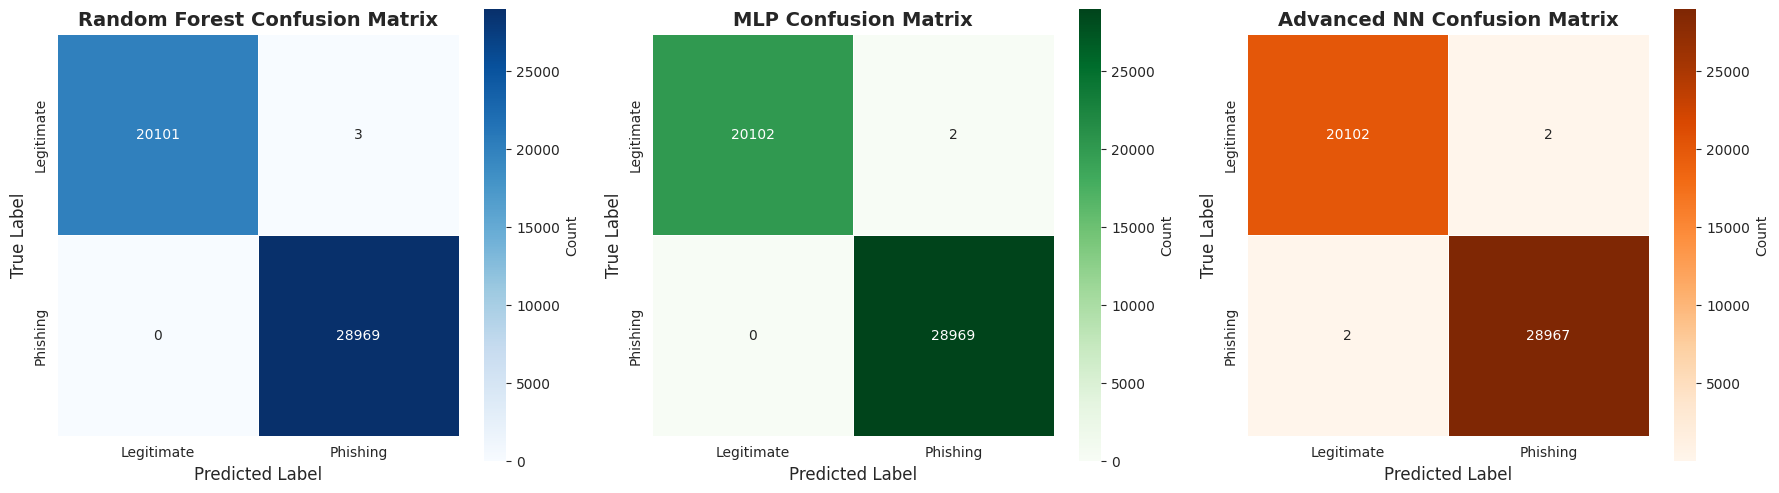


Confusion Matrix Details:

Random Forest:
  True Negatives (TN): 20,101 | False Positives (FP): 3
  False Negatives (FN): 0 | True Positives (TP): 28,969
  Accuracy: 0.9999

MLP:
  True Negatives (TN): 20,102 | False Positives (FP): 2
  False Negatives (FN): 0 | True Positives (TP): 28,969
  Accuracy: 1.0000

Advanced NN:
  True Negatives (TN): 20,102 | False Positives (FP): 2
  False Negatives (FN): 2 | True Positives (TP): 28,967
  Accuracy: 0.9999

2. Generating ROC Curves...


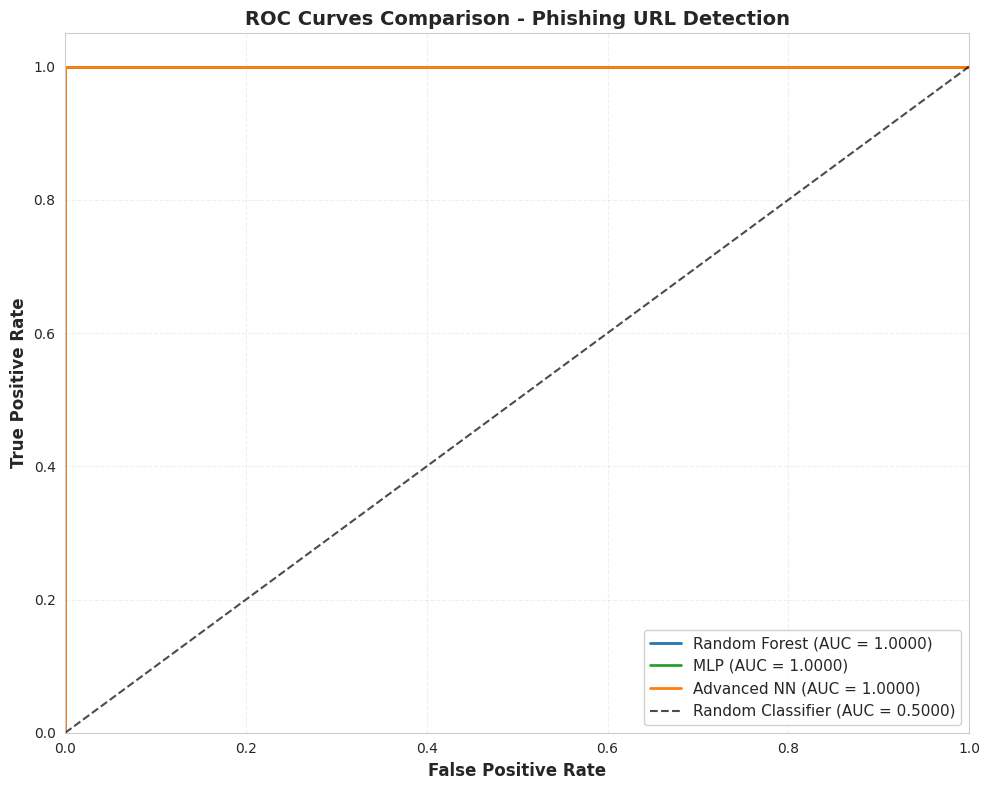


ROC AUC Scores:
  Random Forest: 1.0000
  MLP: 1.0000
  Advanced NN: 1.0000

3. Generating Precision-Recall Curves...


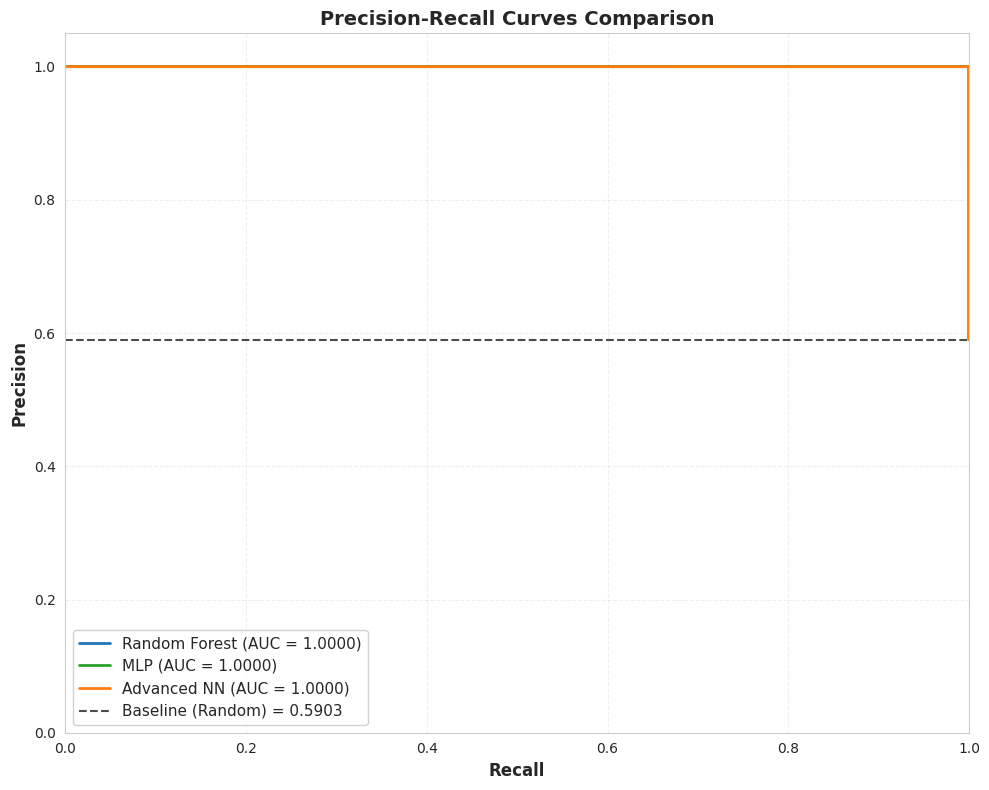


Precision-Recall AUC Scores:
  Random Forest: 1.0000
  MLP: 1.0000
  Advanced NN: 1.0000

4. Generating Metrics Comparison Radar Chart...


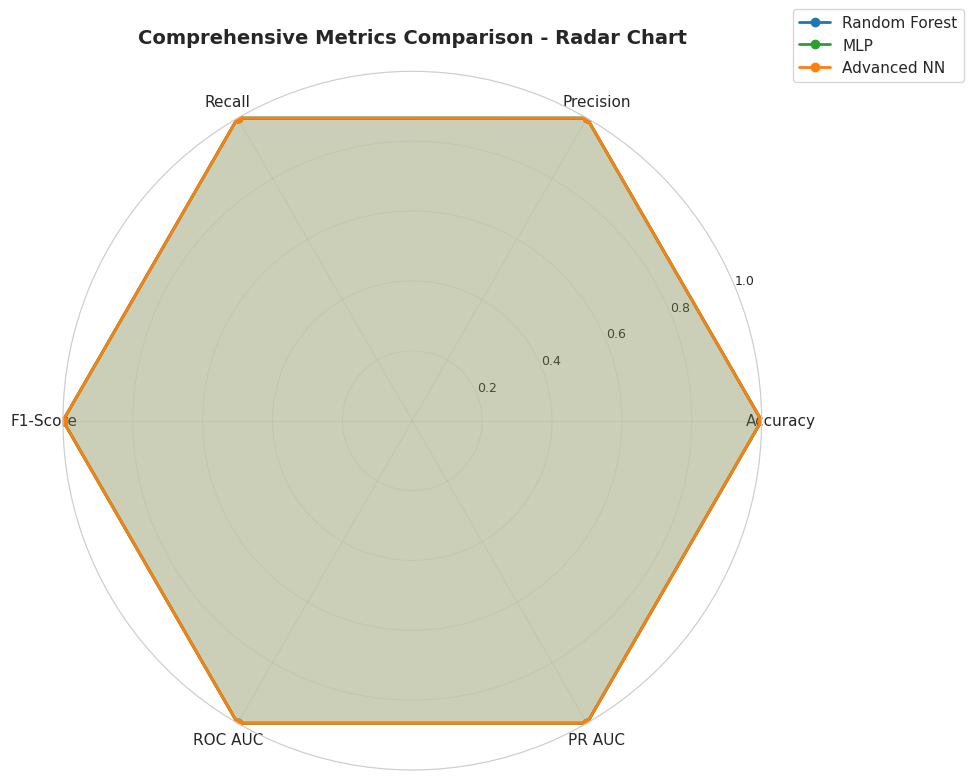


5. Detailed Classification Reports:

Random Forest Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     20104
    Phishing       1.00      1.00      1.00     28969

    accuracy                           1.00     49073
   macro avg       1.00      1.00      1.00     49073
weighted avg       1.00      1.00      1.00     49073


MLP Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     20104
    Phishing       1.00      1.00      1.00     28969

    accuracy                           1.00     49073
   macro avg       1.00      1.00      1.00     49073
weighted avg       1.00      1.00      1.00     49073


Advanced NN Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     20104
    Phishing       1.00      1.00      1.00     28969

    accuracy                           1.00

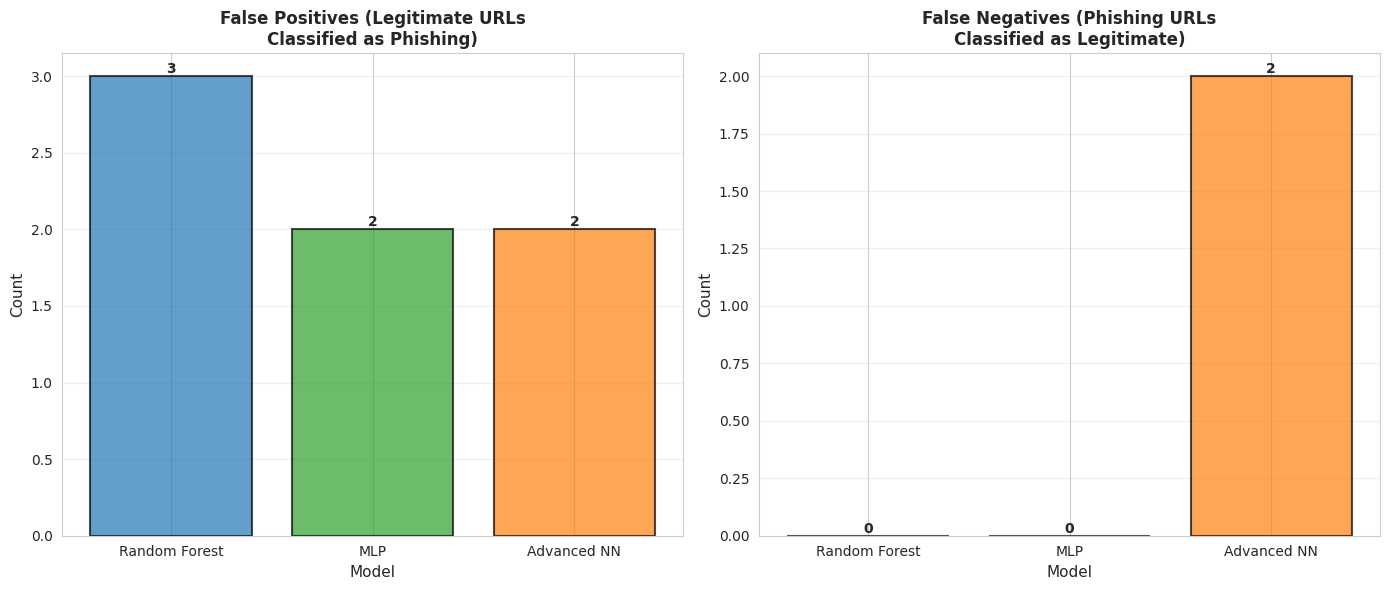


Error Analysis Summary:
  False Positives (FP) - Legitimate URLs misclassified as Phishing:
    Random Forest: 3
    MLP: 2
    Advanced NN: 2

  False Negatives (FN) - Phishing URLs misclassified as Legitimate:
    Random Forest: 0
    MLP: 0
    Advanced NN: 2

7. Generating Performance Metrics Heatmap...


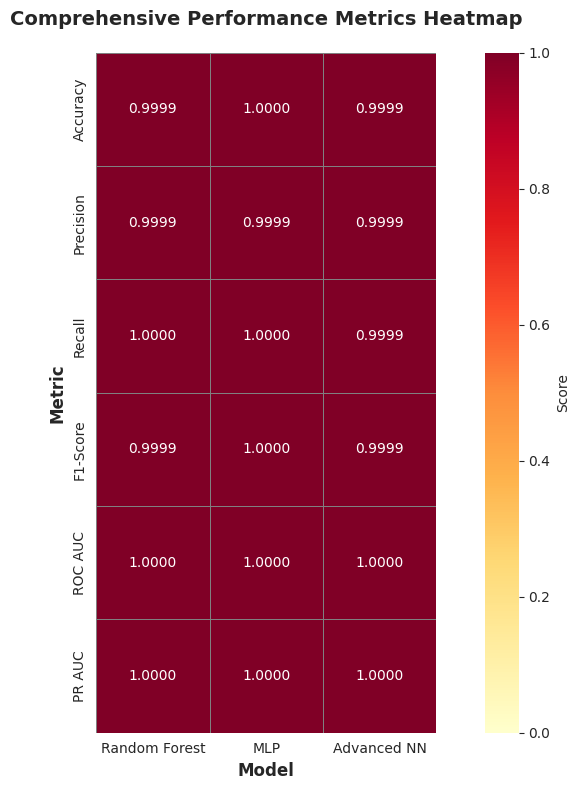


All additional visualizations completed successfully!


In [19]:
print("=" * 70)
print("ADDITIONAL VISUALIZATIONS: Confusion Matrices, ROC Curves, and More")
print("=" * 70)

print("\n1. Generating Confusion Matrices for all models...")

# Get predictions for all models on holdout set
rf_holdout_pred = final_rf.predict(X_holdout_cfs)
rf_holdout_probs = final_rf.predict_proba(X_holdout_cfs)[:, 1]

# Get MLP predictions and probabilities
mlp_holdout_pred, mlp_holdout_true, mlp_holdout_probs = evaluate_model(
    final_mlp, holdout_loader_mlp, device=device, return_probs=True
)

# Get Advanced NN predictions and probabilities
adv_nn_holdout_pred, adv_nn_holdout_true, adv_nn_holdout_probs = evaluate_model(
    final_adv_nn, holdout_loader_adv, device=device, return_probs=True
)

# Create confusion matrices
rf_cm = confusion_matrix(y_holdout, rf_holdout_pred)
mlp_cm = confusion_matrix(mlp_holdout_true, mlp_holdout_pred)
adv_nn_cm = confusion_matrix(adv_nn_holdout_true, adv_nn_holdout_pred)

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_cm = [
    (rf_cm, "Random Forest", "Blues"),
    (mlp_cm, "MLP", "Greens"),
    (adv_nn_cm, "Advanced NN", "Oranges")
]

for idx, (cm, model_name, cmap) in enumerate(models_cm):
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=axes[idx],
                cbar_kws={'label': 'Count'}, square=True, linewidths=0.5)
    axes[idx].set_title(f'{model_name} Confusion Matrix', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontsize=12)
    axes[idx].set_ylabel('True Label', fontsize=12)
    axes[idx].set_xticklabels(['Legitimate', 'Phishing'])
    axes[idx].set_yticklabels(['Legitimate', 'Phishing'])

plt.tight_layout()
plt.show()

# Print confusion matrix details
print("\nConfusion Matrix Details:")
for cm, model_name in [(rf_cm, "Random Forest"), (mlp_cm, "MLP"), (adv_nn_cm, "Advanced NN")]:
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{model_name}:")
    print(f"  True Negatives (TN): {tn:,} | False Positives (FP): {fp:,}")
    print(f"  False Negatives (FN): {fn:,} | True Positives (TP): {tp:,}")
    print(f"  Accuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")

print("\n2. Generating ROC Curves...")

# Calculate ROC curves
rf_fpr, rf_tpr, _ = roc_curve(y_holdout, rf_holdout_probs)
rf_auc = auc(rf_fpr, rf_tpr)

mlp_fpr, mlp_tpr, _ = roc_curve(mlp_holdout_true, mlp_holdout_probs)
mlp_auc = auc(mlp_fpr, mlp_tpr)

adv_nn_fpr, adv_nn_tpr, _ = roc_curve(adv_nn_holdout_true, adv_nn_holdout_probs)
adv_nn_auc = auc(adv_nn_fpr, adv_nn_tpr)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.4f})', linewidth=2, color='#1f77b4')
plt.plot(mlp_fpr, mlp_tpr, label=f'MLP (AUC = {mlp_auc:.4f})', linewidth=2, color='#2ca02c')
plt.plot(adv_nn_fpr, adv_nn_tpr, label=f'Advanced NN (AUC = {adv_nn_auc:.4f})', linewidth=2, color='#ff7f0e')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5000)', linewidth=1.5, alpha=0.7)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves Comparison - Phishing URL Detection', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"\nROC AUC Scores:")
print(f"  Random Forest: {rf_auc:.4f}")
print(f"  MLP: {mlp_auc:.4f}")
print(f"  Advanced NN: {adv_nn_auc:.4f}")

print("\n3. Generating Precision-Recall Curves...")

# Calculate PR curves
rf_precision, rf_recall, _ = precision_recall_curve(y_holdout, rf_holdout_probs)
rf_pr_auc = auc(rf_recall, rf_precision)

mlp_precision, mlp_recall, _ = precision_recall_curve(mlp_holdout_true, mlp_holdout_probs)
mlp_pr_auc = auc(mlp_recall, mlp_precision)

adv_nn_precision, adv_nn_recall, _ = precision_recall_curve(adv_nn_holdout_true, adv_nn_holdout_probs)
adv_nn_pr_auc = auc(adv_nn_recall, adv_nn_precision)

# Plot PR curves
plt.figure(figsize=(10, 8))
plt.plot(rf_recall, rf_precision, label=f'Random Forest (AUC = {rf_pr_auc:.4f})', linewidth=2, color='#1f77b4')
plt.plot(mlp_recall, mlp_precision, label=f'MLP (AUC = {mlp_pr_auc:.4f})', linewidth=2, color='#2ca02c')
plt.plot(adv_nn_recall, adv_nn_precision, label=f'Advanced NN (AUC = {adv_nn_pr_auc:.4f})', linewidth=2, color='#ff7f0e')

# Baseline (random classifier)
baseline = sum(y_holdout) / len(y_holdout)
plt.axhline(y=baseline, color='k', linestyle='--', label=f'Baseline (Random) = {baseline:.4f}', linewidth=1.5, alpha=0.7)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower left', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"\nPrecision-Recall AUC Scores:")
print(f"  Random Forest: {rf_pr_auc:.4f}")
print(f"  MLP: {mlp_pr_auc:.4f}")
print(f"  Advanced NN: {adv_nn_pr_auc:.4f}")

print("\n4. Generating Metrics Comparison Radar Chart...")

# Prepare metrics for radar chart
metrics_data = {
    'Random Forest': [
        holdout_metrics['accuracy'].values[0],
        holdout_metrics['precision'].values[0],
        holdout_metrics['recall'].values[0],
        holdout_metrics['f1'].values[0],
        rf_auc,
        rf_pr_auc
    ],
    'MLP': [
        mlp_holdout_metrics['accuracy'].values[0],
        mlp_holdout_metrics['precision'].values[0],
        mlp_holdout_metrics['recall'].values[0],
        mlp_holdout_metrics['f1'].values[0],
        mlp_auc,
        mlp_pr_auc
    ],
    'Advanced NN': [
        adv_nn_holdout_metrics['accuracy'].values[0],
        adv_nn_holdout_metrics['precision'].values[0],
        adv_nn_holdout_metrics['recall'].values[0],
        adv_nn_holdout_metrics['f1'].values[0],
        adv_nn_auc,
        adv_nn_pr_auc
    ]
}

# Create radar chart
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'PR AUC']
N = len(categories)

# Compute angle for each category
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Complete the circle

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

colors = ['#1f77b4', '#2ca02c', '#ff7f0e']
for idx, (model_name, values) in enumerate(metrics_data.items()):
    values += values[:1]  # Complete the circle
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_title('Comprehensive Metrics Comparison - Radar Chart',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
plt.tight_layout()
plt.show()

print("\n5. Detailed Classification Reports:")
print("\n" + "=" * 70)
print("Random Forest Classification Report:")
print("=" * 70)
print(classification_report(y_holdout, rf_holdout_pred,
                           target_names=['Legitimate', 'Phishing']))

print("\n" + "=" * 70)
print("MLP Classification Report:")
print("=" * 70)
print(classification_report(mlp_holdout_true, mlp_holdout_pred,
                           target_names=['Legitimate', 'Phishing']))

print("\n" + "=" * 70)
print("Advanced NN Classification Report:")
print("=" * 70)
print(classification_report(adv_nn_holdout_true, adv_nn_holdout_pred,
                           target_names=['Legitimate', 'Phishing']))

print("\n6. Generating Error Analysis Visualization...")

# Calculate error rates
rf_tn, rf_fp, rf_fn, rf_tp = rf_cm.ravel()
mlp_tn, mlp_fp, mlp_fn, mlp_tp = mlp_cm.ravel()
adv_nn_tn, adv_nn_fp, adv_nn_fn, adv_nn_tp = adv_nn_cm.ravel()

error_data = {
    'Model': ['Random Forest', 'MLP', 'Advanced NN'],
    'False Positives': [rf_fp, mlp_fp, adv_nn_fp],
    'False Negatives': [rf_fn, mlp_fn, adv_nn_fn]
}

error_df = pd.DataFrame(error_data)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# False Positives
axes[0].bar(error_df['Model'], error_df['False Positives'],
            color=['#1f77b4', '#2ca02c', '#ff7f0e'], alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].set_title('False Positives (Legitimate URLs\nClassified as Phishing)',
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_xlabel('Model', fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(error_df['False Positives']):
    axes[0].text(i, v, f'{int(v):,}', ha='center', va='bottom', fontweight='bold')

# False Negatives
axes[1].bar(error_df['Model'], error_df['False Negatives'],
            color=['#1f77b4', '#2ca02c', '#ff7f0e'], alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].set_title('False Negatives (Phishing URLs\nClassified as Legitimate)',
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=11)
axes[1].set_xlabel('Model', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(error_df['False Negatives']):
    axes[1].text(i, v, f'{int(v):,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nError Analysis Summary:")
print(f"  False Positives (FP) - Legitimate URLs misclassified as Phishing:")
print(f"    Random Forest: {rf_fp:,}")
print(f"    MLP: {mlp_fp:,}")
print(f"    Advanced NN: {adv_nn_fp:,}")
print(f"\n  False Negatives (FN) - Phishing URLs misclassified as Legitimate:")
print(f"    Random Forest: {rf_fn:,}")
print(f"    MLP: {mlp_fn:,}")
print(f"    Advanced NN: {adv_nn_fn:,}")

print("\n7. Generating Performance Metrics Heatmap...")

# Create comprehensive metrics dataframe
metrics_heatmap = pd.DataFrame({
    'Random Forest': [
        holdout_metrics['accuracy'].values[0],
        holdout_metrics['precision'].values[0],
        holdout_metrics['recall'].values[0],
        holdout_metrics['f1'].values[0],
        rf_auc,
        rf_pr_auc
    ],
    'MLP': [
        mlp_holdout_metrics['accuracy'].values[0],
        mlp_holdout_metrics['precision'].values[0],
        mlp_holdout_metrics['recall'].values[0],
        mlp_holdout_metrics['f1'].values[0],
        mlp_auc,
        mlp_pr_auc
    ],
    'Advanced NN': [
        adv_nn_holdout_metrics['accuracy'].values[0],
        adv_nn_holdout_metrics['precision'].values[0],
        adv_nn_holdout_metrics['recall'].values[0],
        adv_nn_holdout_metrics['f1'].values[0],
        adv_nn_auc,
        adv_nn_pr_auc
    ]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'PR AUC'])

plt.figure(figsize=(10, 8))
sns.heatmap(metrics_heatmap, annot=True, fmt='.4f', cmap='YlOrRd',
            cbar_kws={'label': 'Score'}, linewidths=0.5, linecolor='gray',
            square=True, vmin=0, vmax=1)
plt.title('Comprehensive Performance Metrics Heatmap',
         fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Metric', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("All additional visualizations completed successfully!")
print("=" * 70)
